In [1]:
import pandas as pd
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from datetime import datetime, timedelta

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
import os, sys
path_name= os.path.dirname(os.path.abspath(os.path.dirname(os.getcwd())))
sys.path.append(path_name)

In [3]:
from _element import feature_control as ft_c
from _element import varr
from _element import calculations as calc
from _element.result_control import Result

from _alg.prophet import Prophet_timeseries
from _alg.arima import Arima_timeseries

from _evaluation.cross_validation import Cross_Validation
from _evaluation import compare

In [4]:
INPUT_FILENAME= 'KPP일별투입(10_17)_withallobj2.xlsx'

In [5]:
df_raw= ft_c.xlsx_opener(varr.PJ_DIR+varr.DF_DIR, INPUT_FILENAME)
df_temp= ft_c.xlsx_opener(varr.PJ_DIR+varr.TEMP_DATA_DIR, 'temp_data_merged.xlsx')

In [6]:
y_col= df_raw['raw'].columns.values.tolist()

In [7]:
try:
    y_col.remove('ds')
except ValueError:
    pass

In [8]:
x_col= df_temp['raw'].columns.values.tolist()

In [9]:
df_raw['raw']['ds']= pd.to_datetime(df_raw['raw']['ds'], box=True, format= '%Y/%m/%d', exact=True)
df_temp['raw']['ds']= pd.to_datetime(df_temp['raw']['ds'], box=True, format= '%Y/%m/%d', exact=True)
df_raw['raw']= pd.merge(df_raw['raw'], df_temp['raw'], how='inner', on='ds')

In [10]:
ft_c.add_division(df_raw, 'raw', 7, start_num= 3)

In [11]:
df_raw['raw']['seasonality_7,3']= df_raw['raw']['seasonality_7,3'].replace(to_replace= [0,1,2,3,4,5,6], value= ['mon','tue','wed','thu','fri','sat','sun'])

In [12]:
ft_c.divide_by(df_raw, 'raw', 'seasonality_7,3')

In [13]:
for i in ['mon','tue','wed','thu','fri','sat','sun']:
    keyname= (i, )
    ft_c.divide_multiple_y(df_raw, keyname, y_col, x_col, checkpoint= str(i))

In [14]:
df_raw

{'1041_fri':              ds   temp_max   temp_min  rain_amount      y
 1    2010-07-02  25.799999  22.700001         70.0   2740
 8    2010-07-09  29.299999  21.799999          0.0   5268
 15   2010-07-16  27.100000  21.700001         52.0   4041
 22   2010-07-23  25.000000  23.200001          2.0   9022
 29   2010-07-30  30.799999  25.000000          0.0   6348
 36   2010-08-06  30.500000  24.500000         62.0   4082
 43   2010-08-13  29.299999  24.200001          0.0   3426
 50   2010-08-20  32.000000  25.200001          0.0   4137
 57   2010-08-27  31.400000  24.400000         83.0   5458
 64   2010-09-03  29.400000  23.299999          2.0   3430
 71   2010-09-10  25.500000  22.400000        130.0   6006
 78   2010-09-17  28.600000  21.900000          0.0   6746
 85   2010-09-24  22.900000  13.900000          0.0   2094
 92   2010-10-01  21.000000  13.800000          0.0   5058
 99   2010-10-08  23.000000  15.500000          0.0   7986
 106  2010-10-15  16.799999  10.300000      

In [15]:
r= Result()

In [16]:
cv2= Cross_Validation(df_raw)

In [17]:
cv2.slice('y', x_col, forecastday= varr.FORECASTDAY//7)

In [18]:
cv2._data

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [18]:
prpt_withobj= Prophet_timeseries(cv= True)

In [19]:
prpt_withobj.add_model('obj', 'day', regressor= False)

In [20]:
prpt_withobj.log_fit('obj', txs_traintest= cv2._data)

In [21]:
prpt_withobj.forecast('obj', forecast_dict= r.forecast_dict)

C:\Nextop\nextop-engine\nextop_engine\_alg\prophet.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  result_forecast['ds'], box=True, format= '%Y/%m/%d', exact=True


In [27]:
r.forecast_dict

OrderedDict([('1041_result',
              {'MAPE': inf,
               'MAPE_div_std': 45.176377062788234,
               'MAPE_with_std': 64.521101674050684,
               'RMSE': 7236.2990817547798,
               'forecast': [          ds   temp_max   temp_min  rain_amount      y          yhat
                0 2017-02-17   4.800000  -7.200000          0.0   7731  10391.117349
                0 2017-02-18   2.100000  -6.200000          0.0   6970  44947.217511
                0 2017-02-19   5.000000  -0.400000          3.2      0      0.597233
                0 2017-02-20   0.600000  -6.400000          0.0   6482  18878.129808
                0 2017-02-21   4.900000  -4.600000          0.0   5250   7056.858401
                0 2017-02-22   3.400000  -3.100000          3.1   6997   8074.751458
                0 2017-02-23   1.600000  -5.700000          0.0   7140   8795.574704
                0 2017-04-28  20.700001   9.300000          0.0  10710   8189.504039
                0 20

In [23]:
r.merge_result(list(map(str, y_col)))

In [24]:
r.err_rate()

C:\Nextop\nextop-engine\nextop_engine\_element\calculations.py:13: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [25]:
r.avg_result(list(map(str, y_col)))

In [26]:
r.print_err_rate()

RMSE with segment 1041_result: 7236.2991
MAPE with segment 1041_result: inf
MAPE_with_std with segment 1041_result: 64.5211
MAPE_div_std with segment 1041_result: 45.1764
sMAPE with segment 1041_result: 50.3479


RMSE with segment 1057_result: 1877.0739
MAPE with segment 1057_result: inf
MAPE_with_std with segment 1057_result: 68.7431
MAPE_div_std with segment 1057_result: 60.1944
sMAPE with segment 1057_result: 98.8725


RMSE with segment 1091_result: 360.9349
MAPE with segment 1091_result: inf
MAPE_with_std with segment 1091_result: 91.6126
MAPE_div_std with segment 1091_result: 79.8048
sMAPE with segment 1091_result: 144.6485


RMSE with segment 1117_result: 0.9943
MAPE with segment 1117_result: inf
MAPE_with_std with segment 1117_result: 3362.4715
MAPE_div_std with segment 1117_result: 3462.4715
sMAPE with segment 1117_result: 200.0000


RMSE with segment 1261_result: 2109.7241
MAPE with segment 1261_result: inf
MAPE_with_std with segment 1261_result: 53.9331
MAPE_div_std with segm

1242


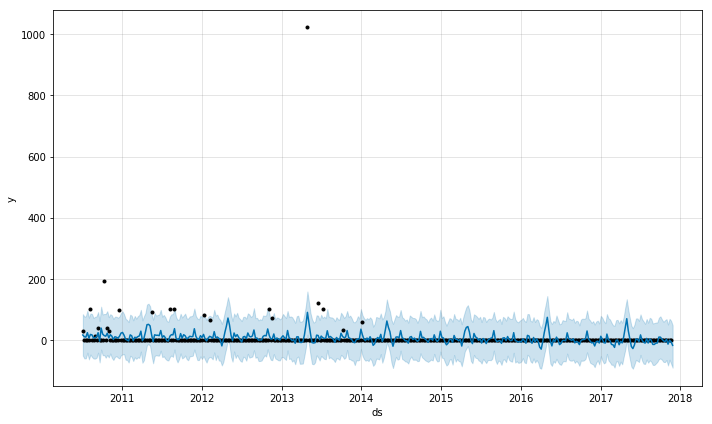

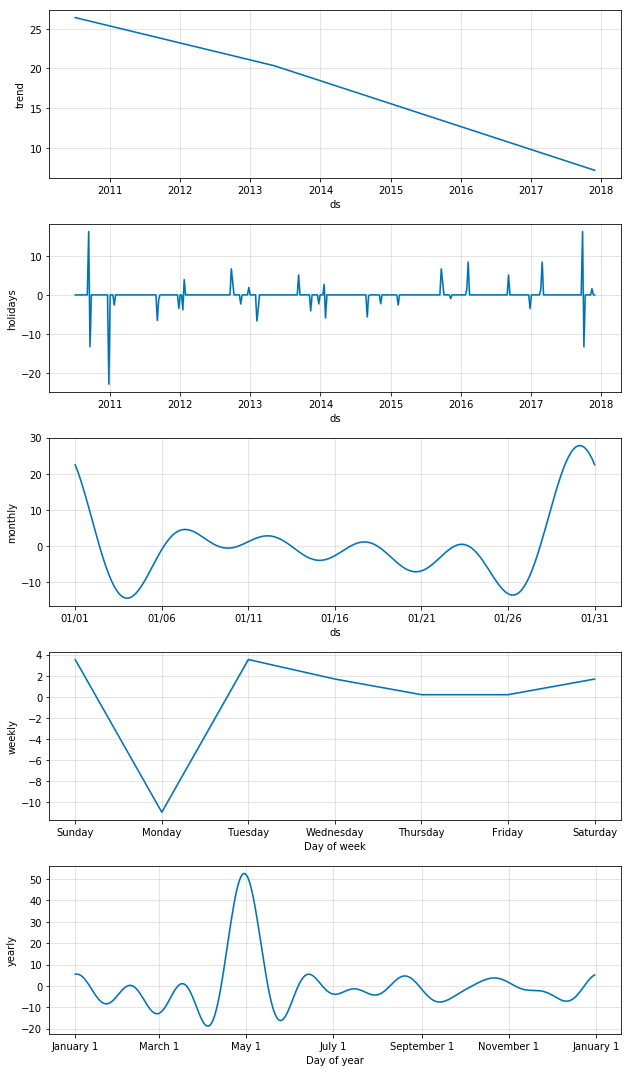

1261


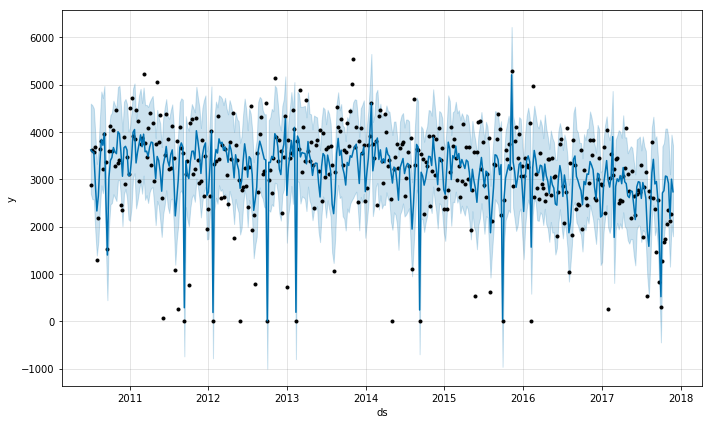

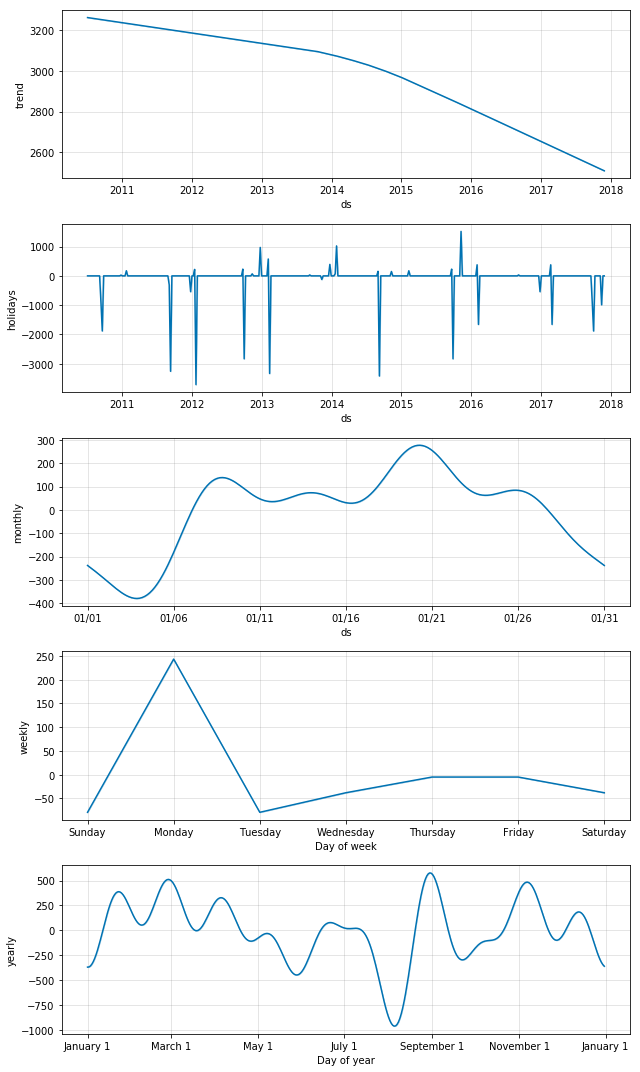

1298


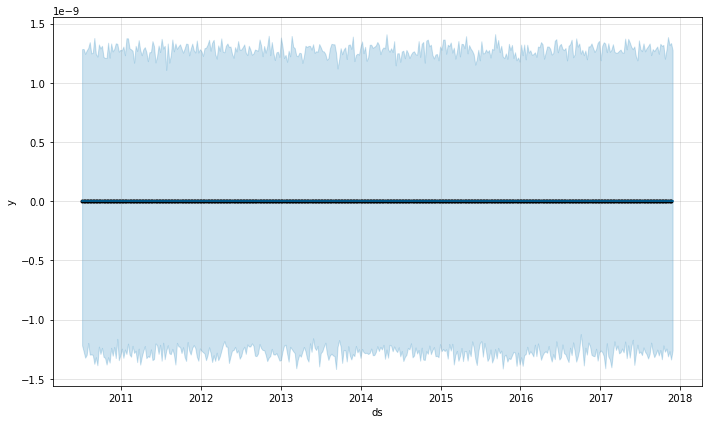

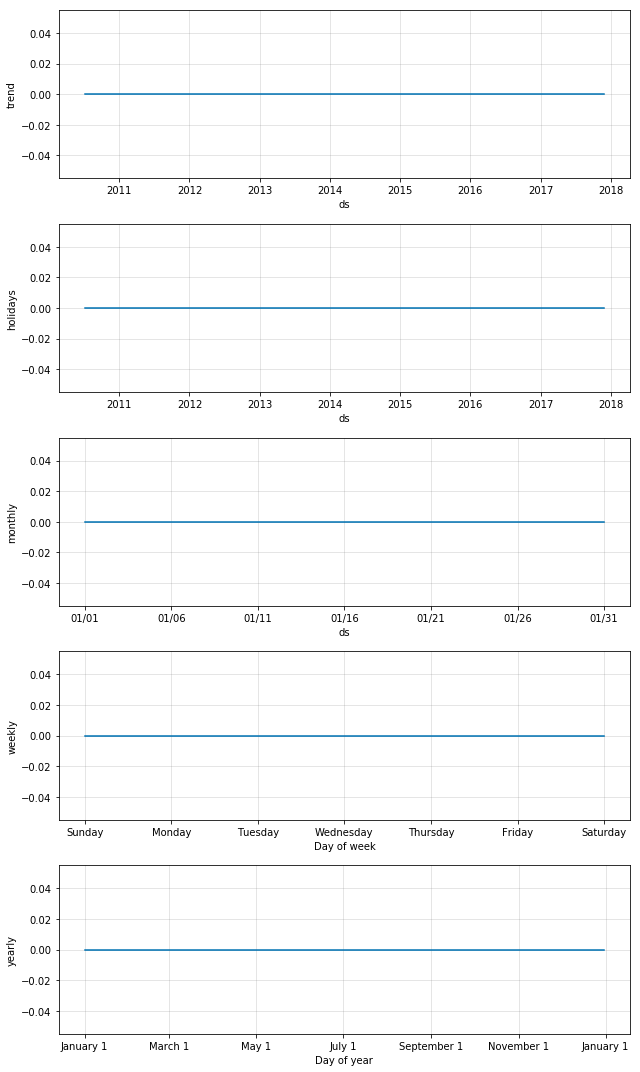

1355


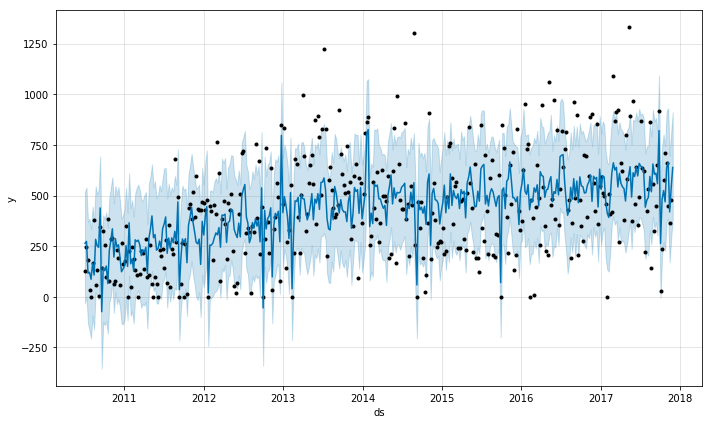

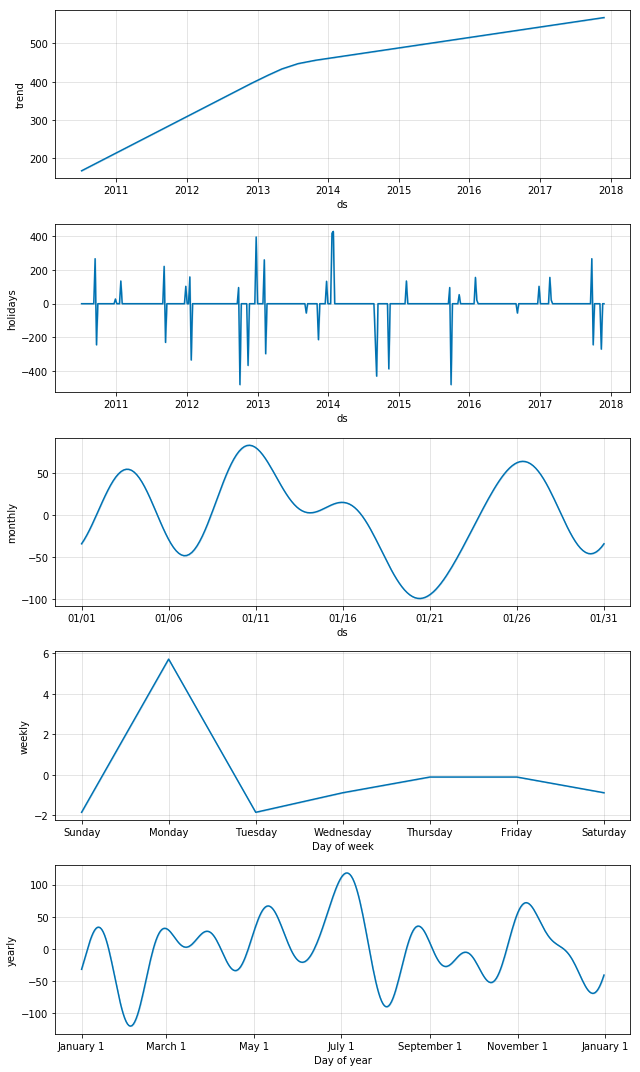

1373


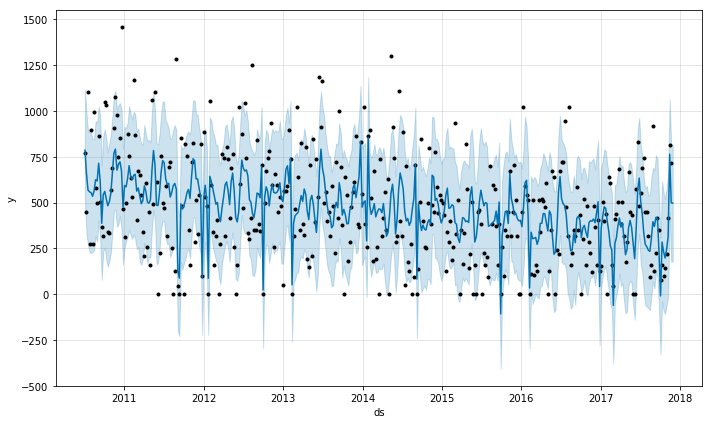

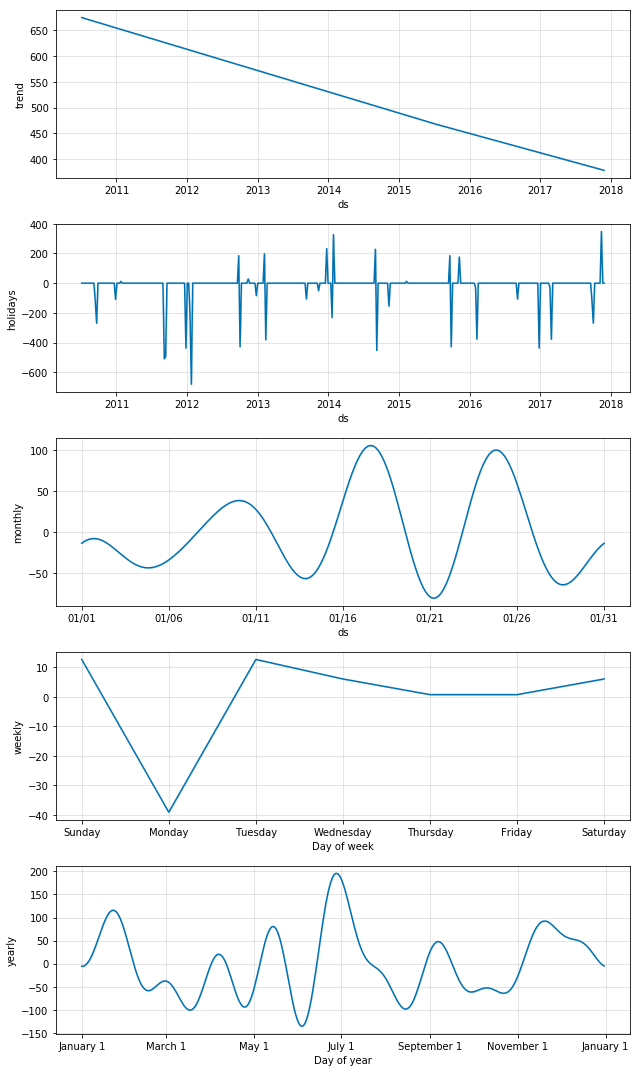

1375


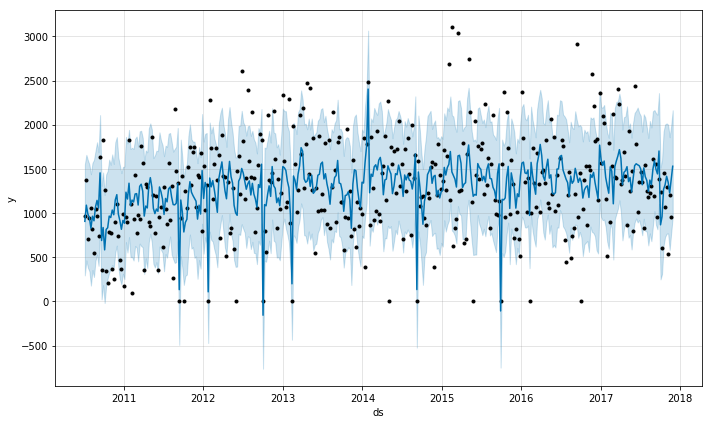

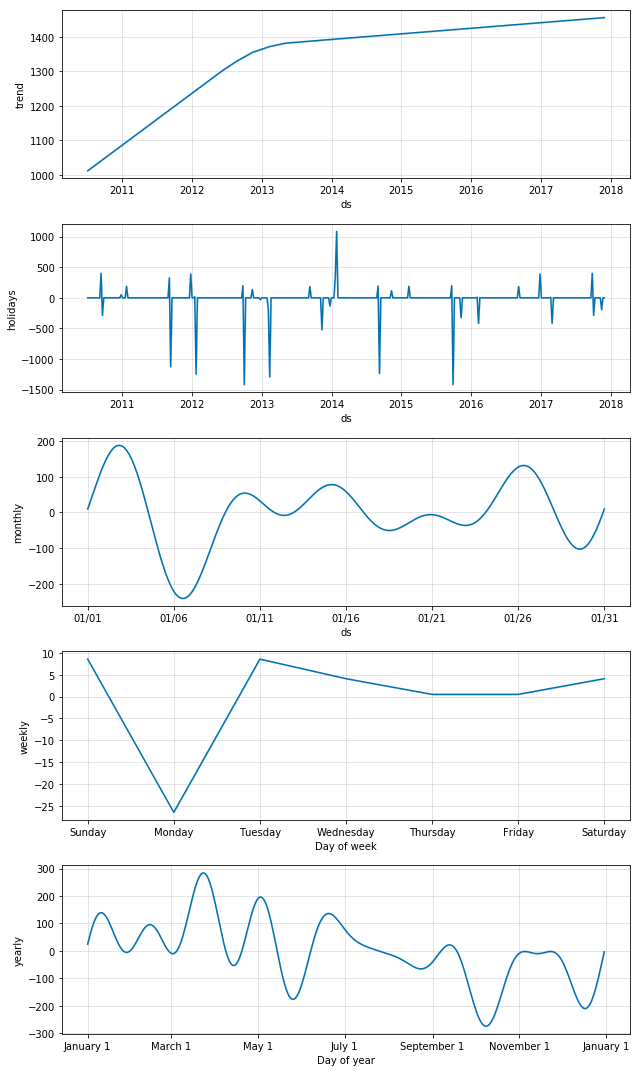

1376


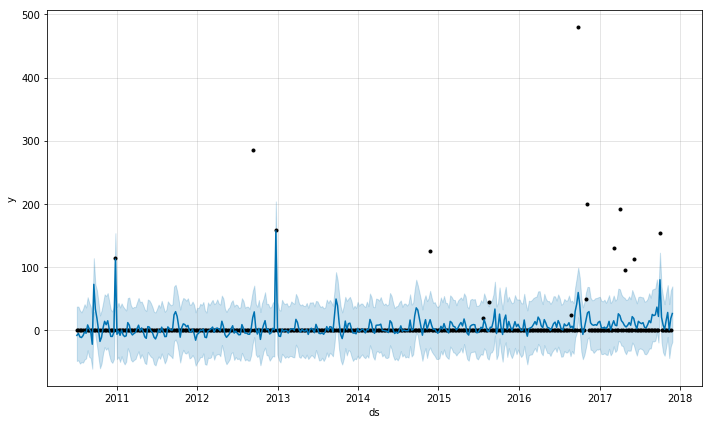

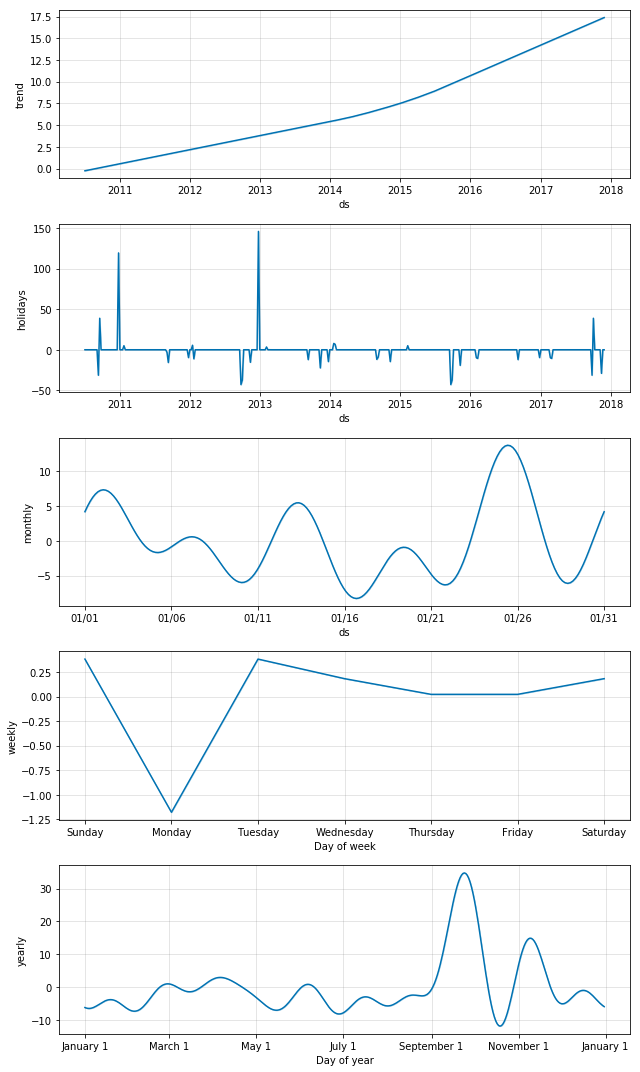

1390


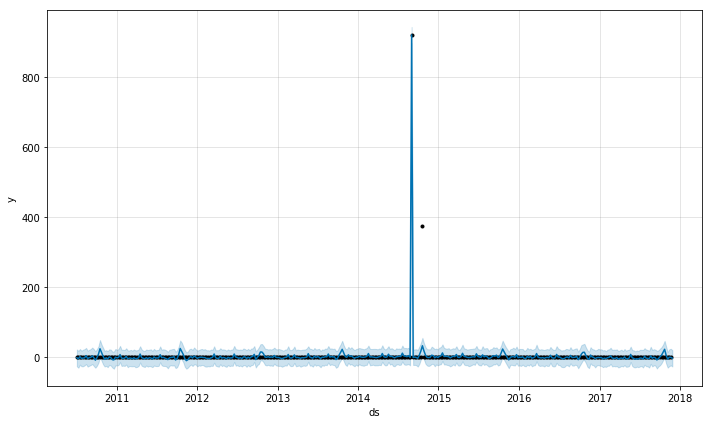

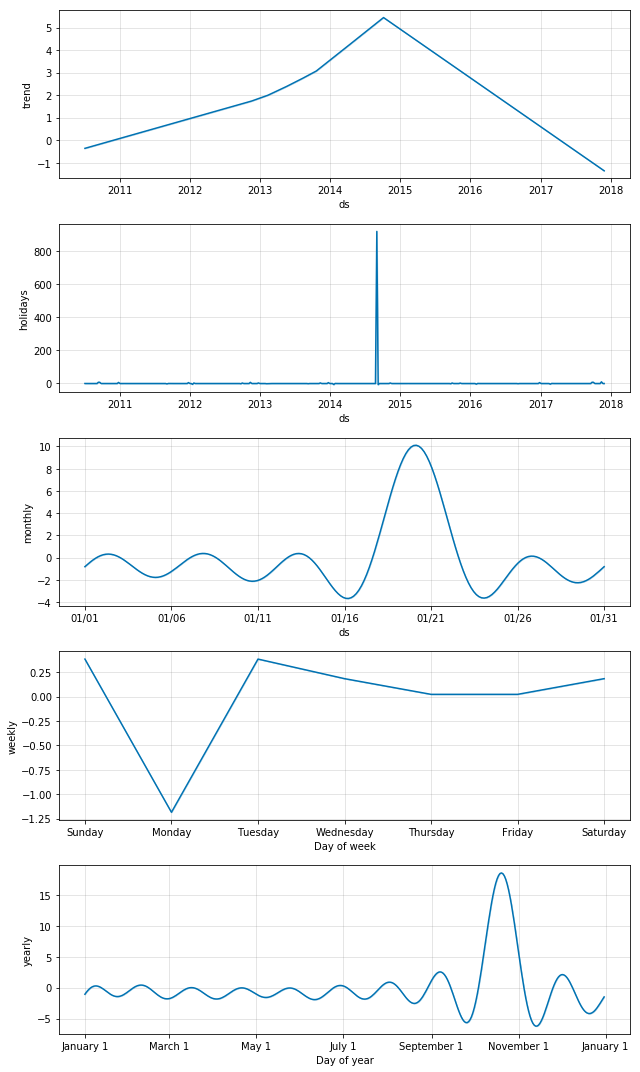

1396


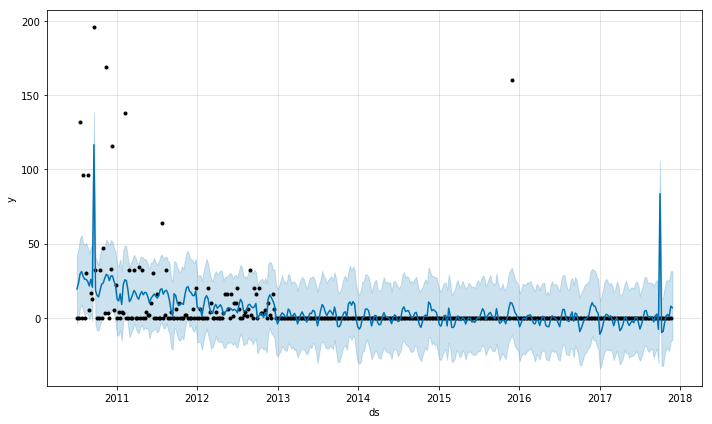

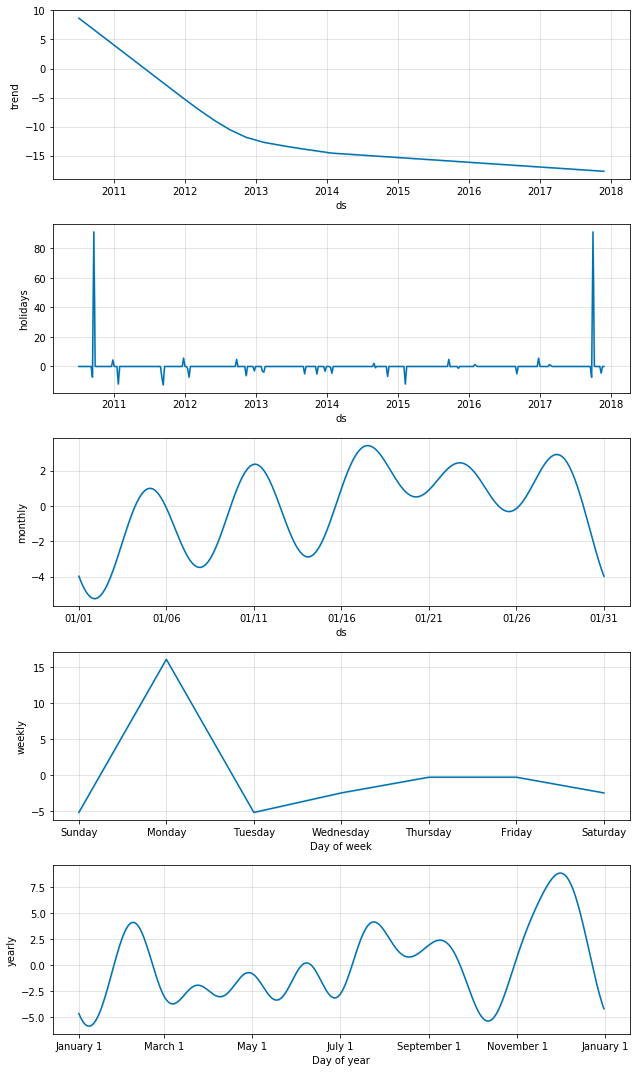

1627


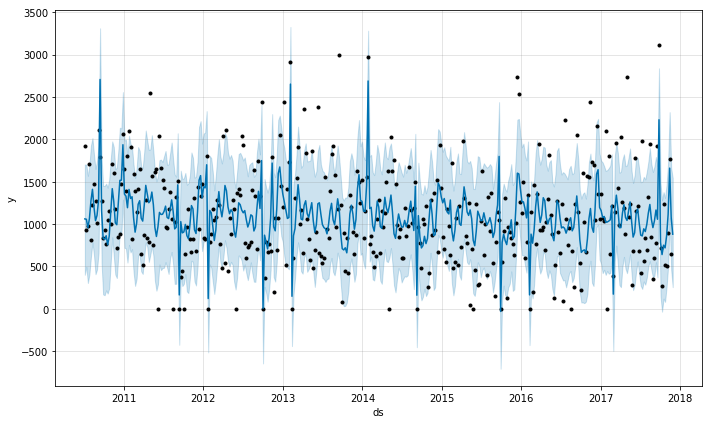

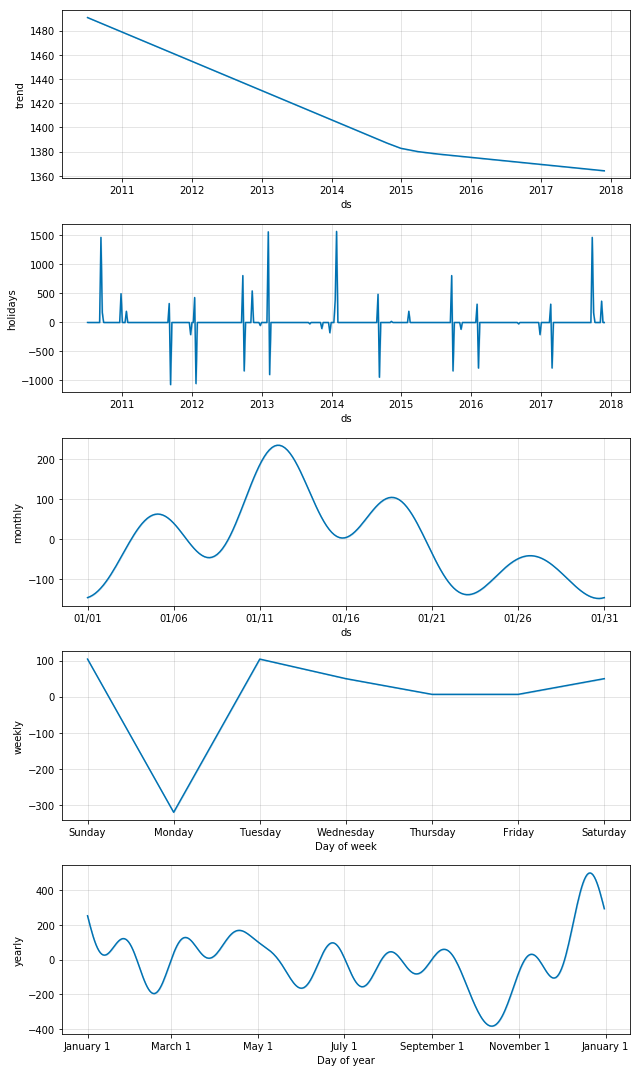

In [50]:
for i in list(map(str, y_col))[10:20]:
    print(i)
    prpt_withobj.plot('obj_{}_mon_0'.format(i))

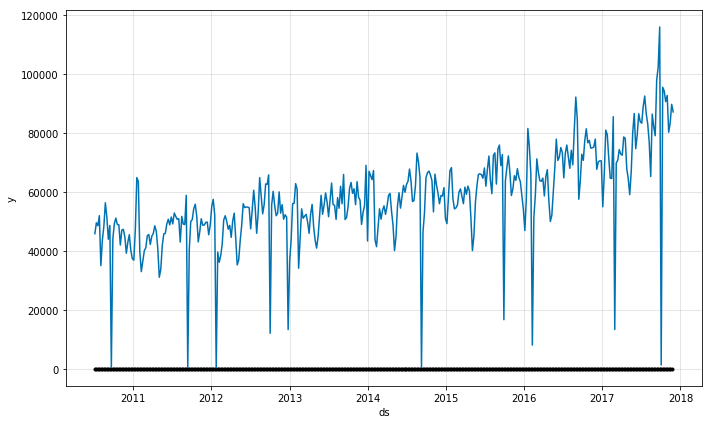

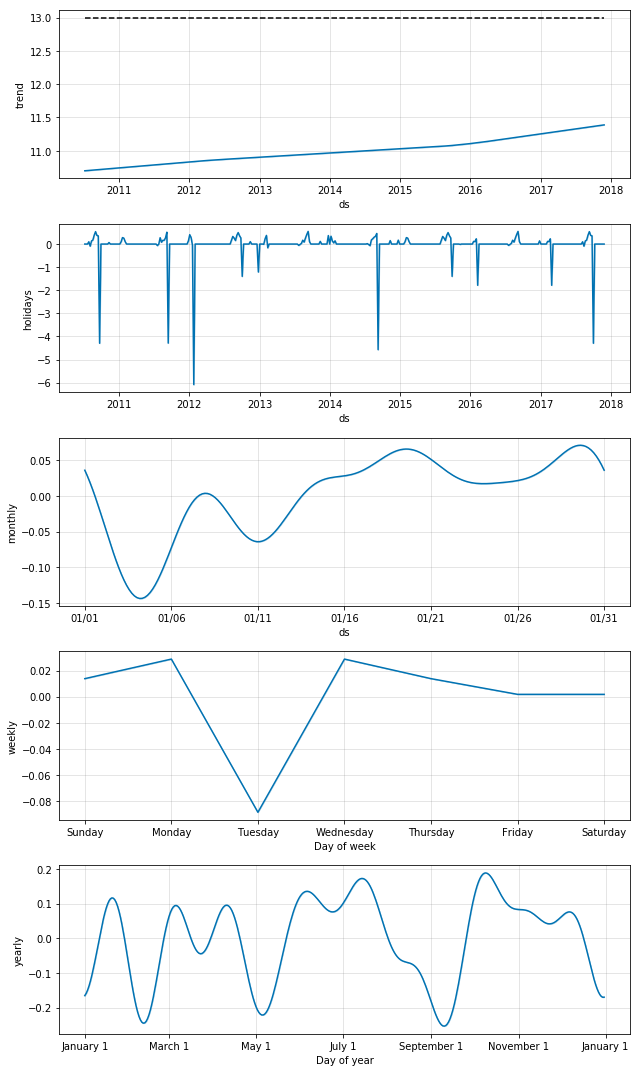

In [29]:
prpt_withobj.plot('obj_1815_tue_0')

In [ ]:


y_true, y_pred = np.array(y_true), np.array(y_pred)
(np.sum(np.abs(y_true - y_pred)) / np.sum(y_true + y_pred)) * 2 * 100